# 1- Data Labeling

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = 13, 6 
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] =False
%config InlineBackend.figure_format = 'retina'

<Axes: xlabel='time'>

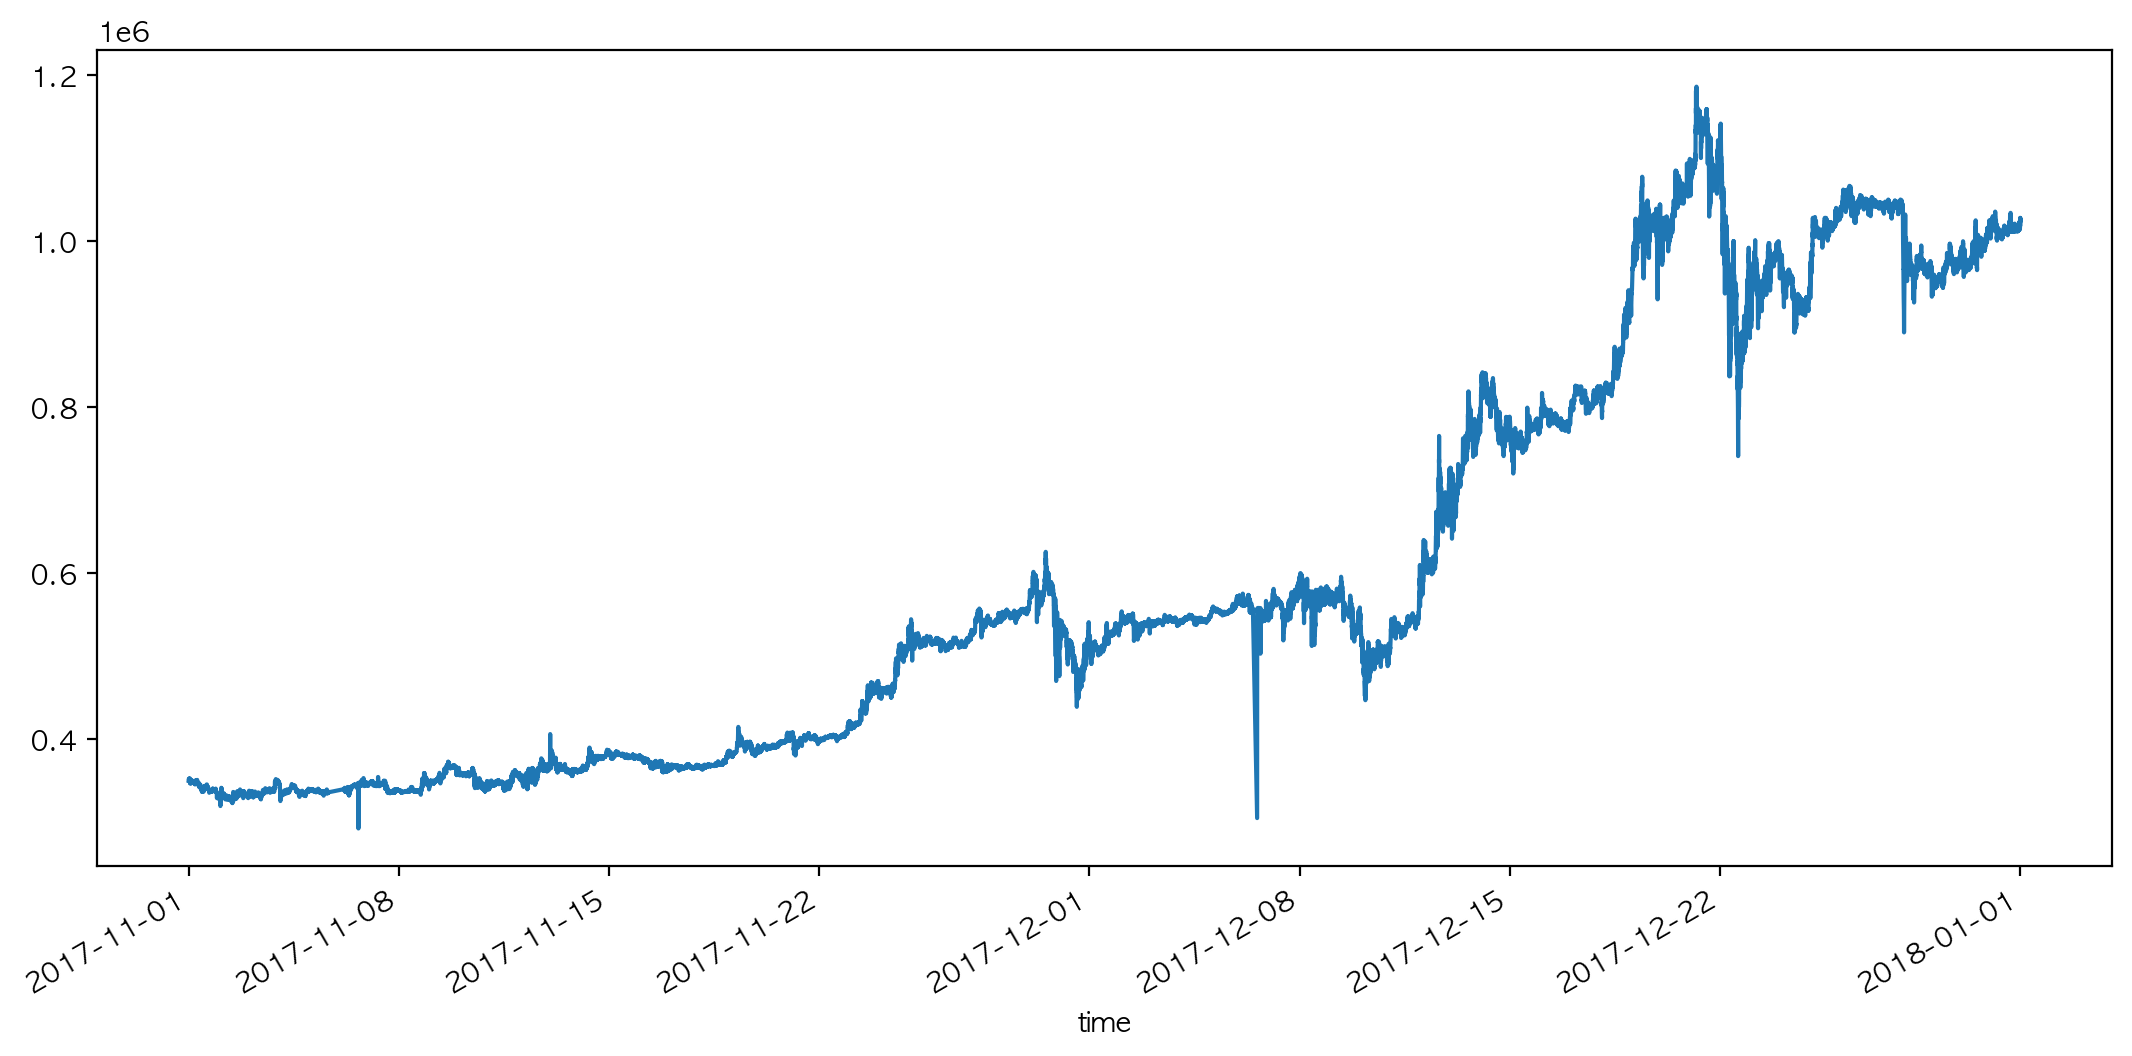

In [6]:
# 데이터 경로
DATA_PATH = '/Users/kenny_jung/aiffel/workplace/quest_0304/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

In [7]:
modify_data.head()

,open,high,low,close,volume
time,,,,,
2017-09-25 03:00:00,324500,325500,322000,324000,52.477251
2017-09-25 03:01:00,324000,324000,322500,324000,39.061889
2017-09-25 03:02:00,322500,324500,322500,324500,12.794000
2017-09-25 03:05:00,324000,324000,323000,324000,33.365246
2017-09-25 03:06:00,324000,325000,322500,324000,46.224544


## ① Price Change Direction 적용하기

In [8]:
# window 지정
window = 10

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)  # compare with the price of windows days ago

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)  # convert to series


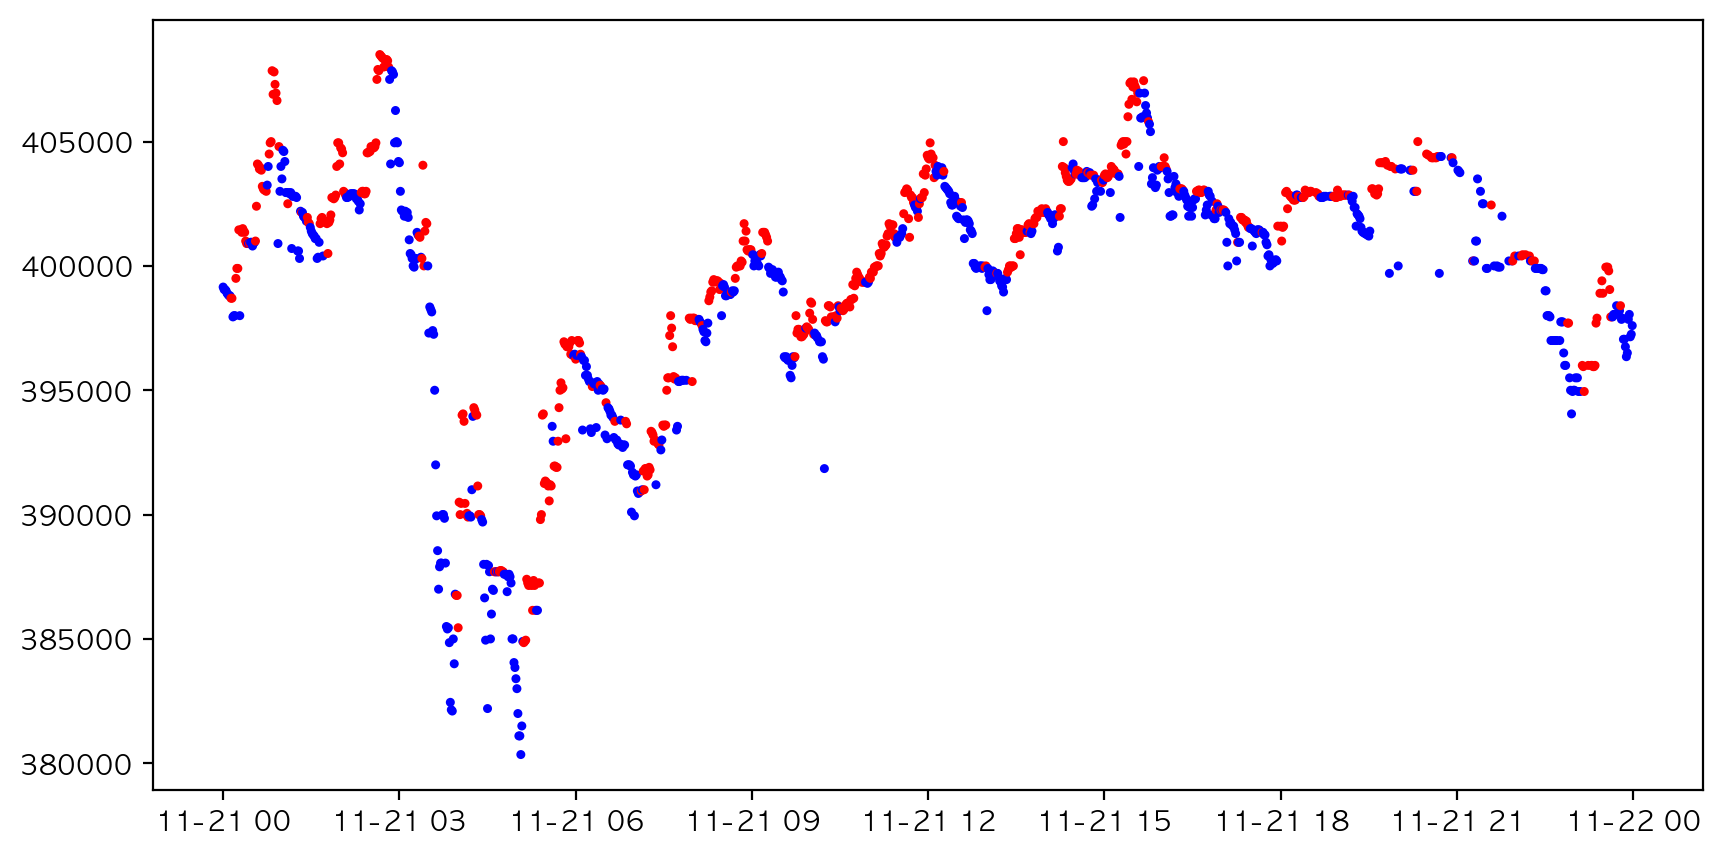

In [9]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close'] # Select data from 2017-11-21 to the end

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21'] # Select the signal of 2017-11-21 to the end

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue') # Color of the signal (increase: red, decrese: blue)

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'], s = 5)

## ② Using Moving Average 적용하기

In [10]:
# momentum_signal 
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)  # compare with the rolling mean price of windows days ago

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)  # convert to series

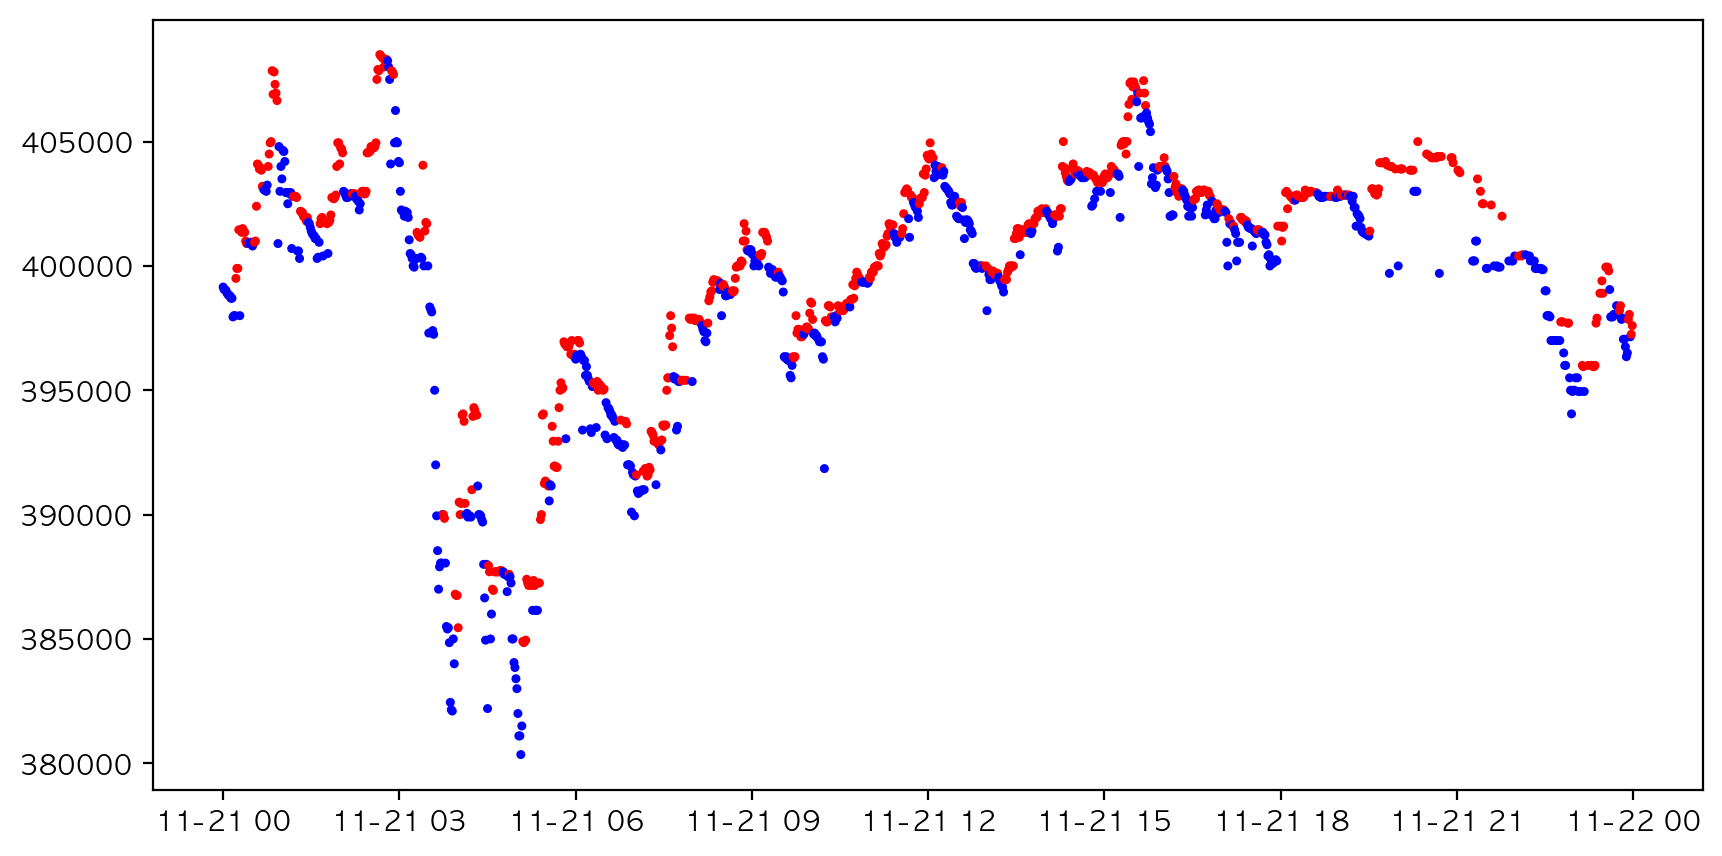

In [11]:
sub_data = modify_data.loc['2017-11-21', 'close']  # Data of the day
c_sig = s_momentum_signal.loc['2017-11-21']  # Signal of the day
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')  # Color of the signal (above: red, below: blue)

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'], s = 5)

## ③ Local Min-Max 적용하기

In [12]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [13]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인 
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

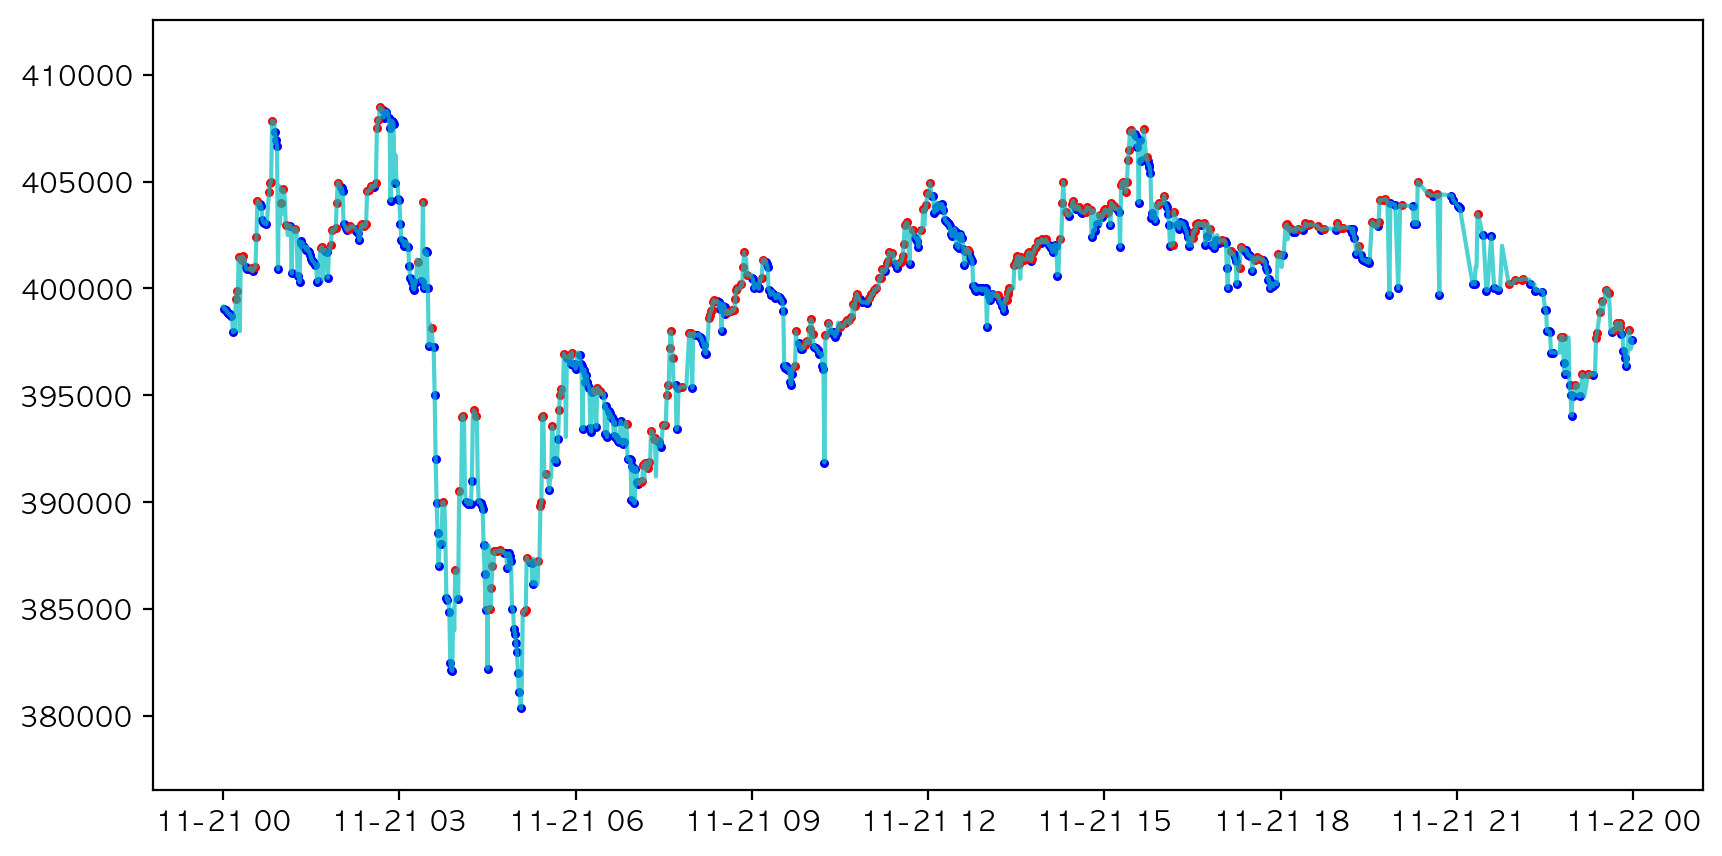

In [14]:
# subplots 및 plot 생성
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c', alpha=0.7)

# min_time, local_min을 활용한 scatter plot 생성
ax.scatter(mins.min_time, mins.local_min, c='blue', s = 5)

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(maxes.max_time, maxes.local_max, c='red', s = 5)

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

## ④ Trend Scanning 적용하기

In [15]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [16]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [20]:
# 이 코드 블럭은 실행에 20~30분정도 걸립니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [03:23<00:00, 164.40it/s]


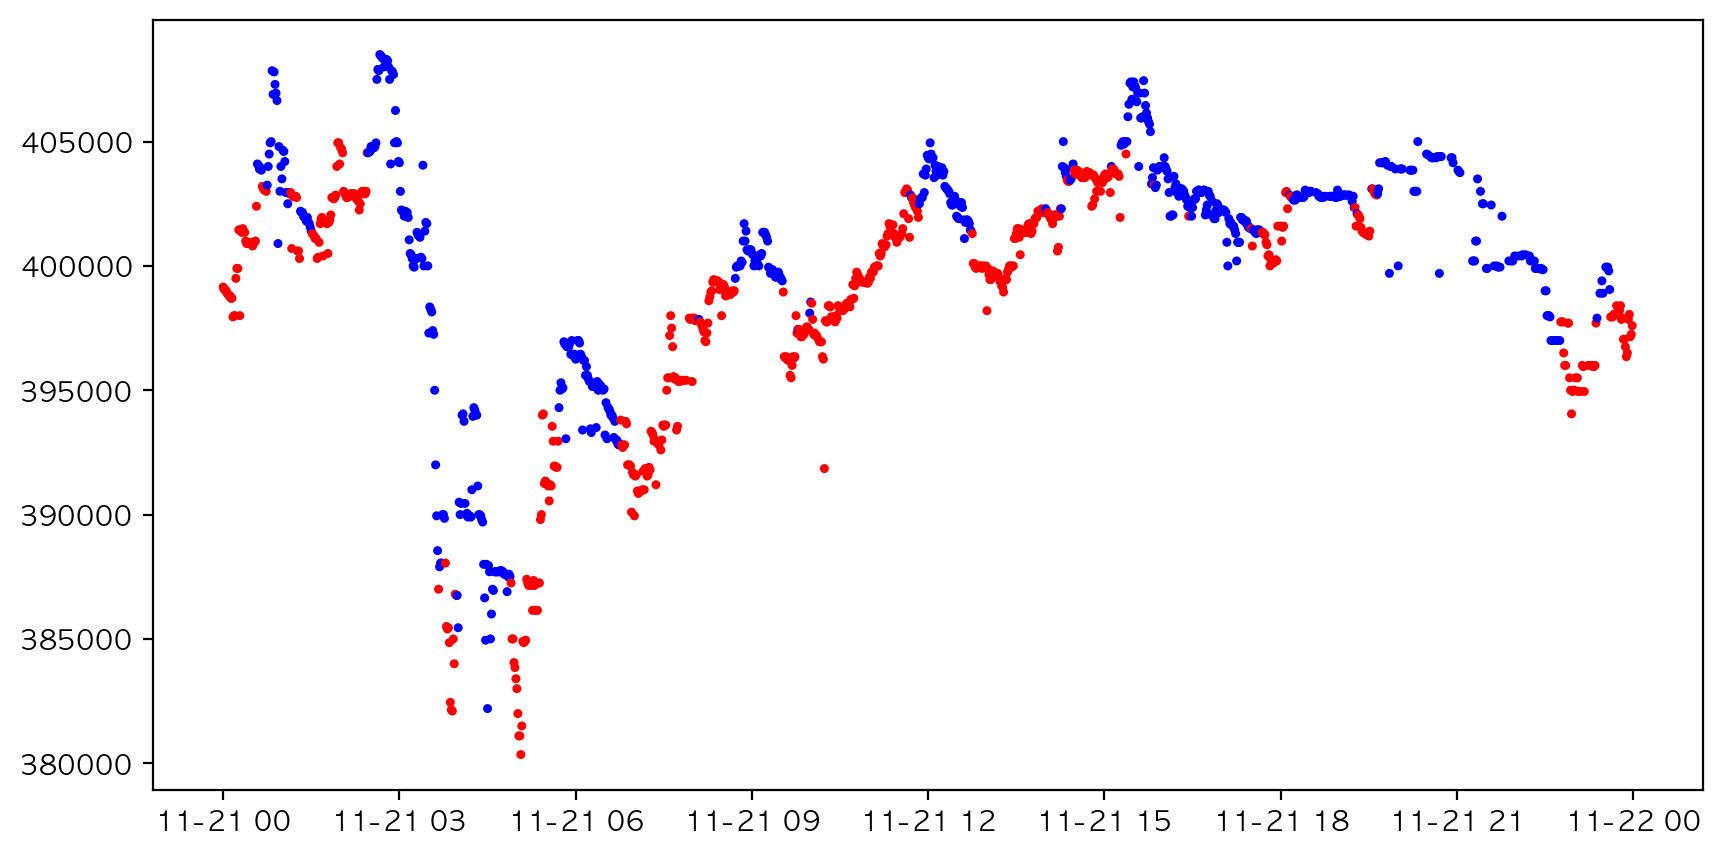

In [22]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'], s = 5)

# 2- Feature Engineering

## ① 환경구성 및 데이터 불러오기

In [29]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
# sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [31]:
# 데이터 경로 설정
DATA_PATH = '/Users/kenny_jung/aiffel/workplace/quest_0304/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

## ② Technical Index 적용하기

In [32]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [33]:
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr
time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,1416.425464,0.361107,652.357742,20.661135,-0.018034,23.066052,-225.0,-35.0,52.934202,-0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,1574.782918,0.349329,482.768654,21.007559,-0.016660,23.029259,-2100.0,-35.0,44.041843,-62.5
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,1517.304626,0.342452,280.010175,21.537826,-0.015683,22.971985,-1925.0,-35.0,41.083991,-87.5


In [35]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [36]:
df_.join(df_label_data).dropna()

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30,t_value
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1017500,1019000,1017500,1018500,30.272135,0.363435,719.550725,56.072055,8.940793e+11,0.036253,...,-42.105263,-0.678913,0.000000,-0.318982,0.000000,-0.818597,0.004438,2348.636190,34.165561,1.0
2018-01-01 00:44:00,1018500,1021500,1018000,1021500,25.131162,0.368141,10053.792799,54.776628,2.480511e+12,0.103776,...,-10.526316,-0.294524,0.007396,-0.266406,0.000490,-0.363379,0.006404,2465.217810,34.384398,1.0
2018-01-01 00:45:00,1021500,1022000,1020000,1020000,17.108609,0.365340,5589.204549,56.034287,3.376449e+12,0.048901,...,-27.777778,0.260837,0.001965,-0.341287,0.000981,-0.293731,0.006413,2505.453821,34.506907,1.0
2018-01-01 00:46:00,1020000,1025000,1019000,1025000,44.289130,0.358534,32571.260299,50.196394,2.908715e+12,0.191981,...,-0.000000,2.165060,0.008362,-0.091323,0.003918,-0.168955,0.010848,2848.118960,33.965563,1.0
2018-01-01 00:47:00,1020000,1020000,1019000,1019000,10.224255,0.327429,20831.661354,45.446741,-6.760619e+11,0.157254,...,-52.173913,0.547160,0.001474,-0.855580,0.000491,-0.723566,0.003447,2855.524994,34.696090,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,-0.000000,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354,0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,-62.500000,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774,0.0
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,-87.500000,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495,0.0


In [37]:
df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1]

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [38]:
# RandomForest 모델 적용
rfc = RandomForestClassifier(class_weight='balanced')

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

## ③ Feature Selection methods 적용하기

### MDA, Mean Decrease Accuracy¶

In [39]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.048440,0.001789
volume_fi,0.041859,0.002384
volume_mfi,0.044385,0.002469
volume_sma_em,0.037157,0.001973
volume_vpt,0.024972,0.001481
volatility_atr,0.077634,0.003177
volatility_ui,0.050061,0.002409
trend_macd_diff,0.084109,0.004380
trend_adx,0.051955,0.002007
trend_trix,0.073047,0.003528


In [40]:
# MDA, Mean Decrease Accuracy
# svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
# cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
# feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
cv = KFold(n_splits=10)  # n_splits를 10으로 변경
feat_imp_mda = imp.mean_decrease_accuracy(rf, X_sc, y, cv_gen=cv)

In [41]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

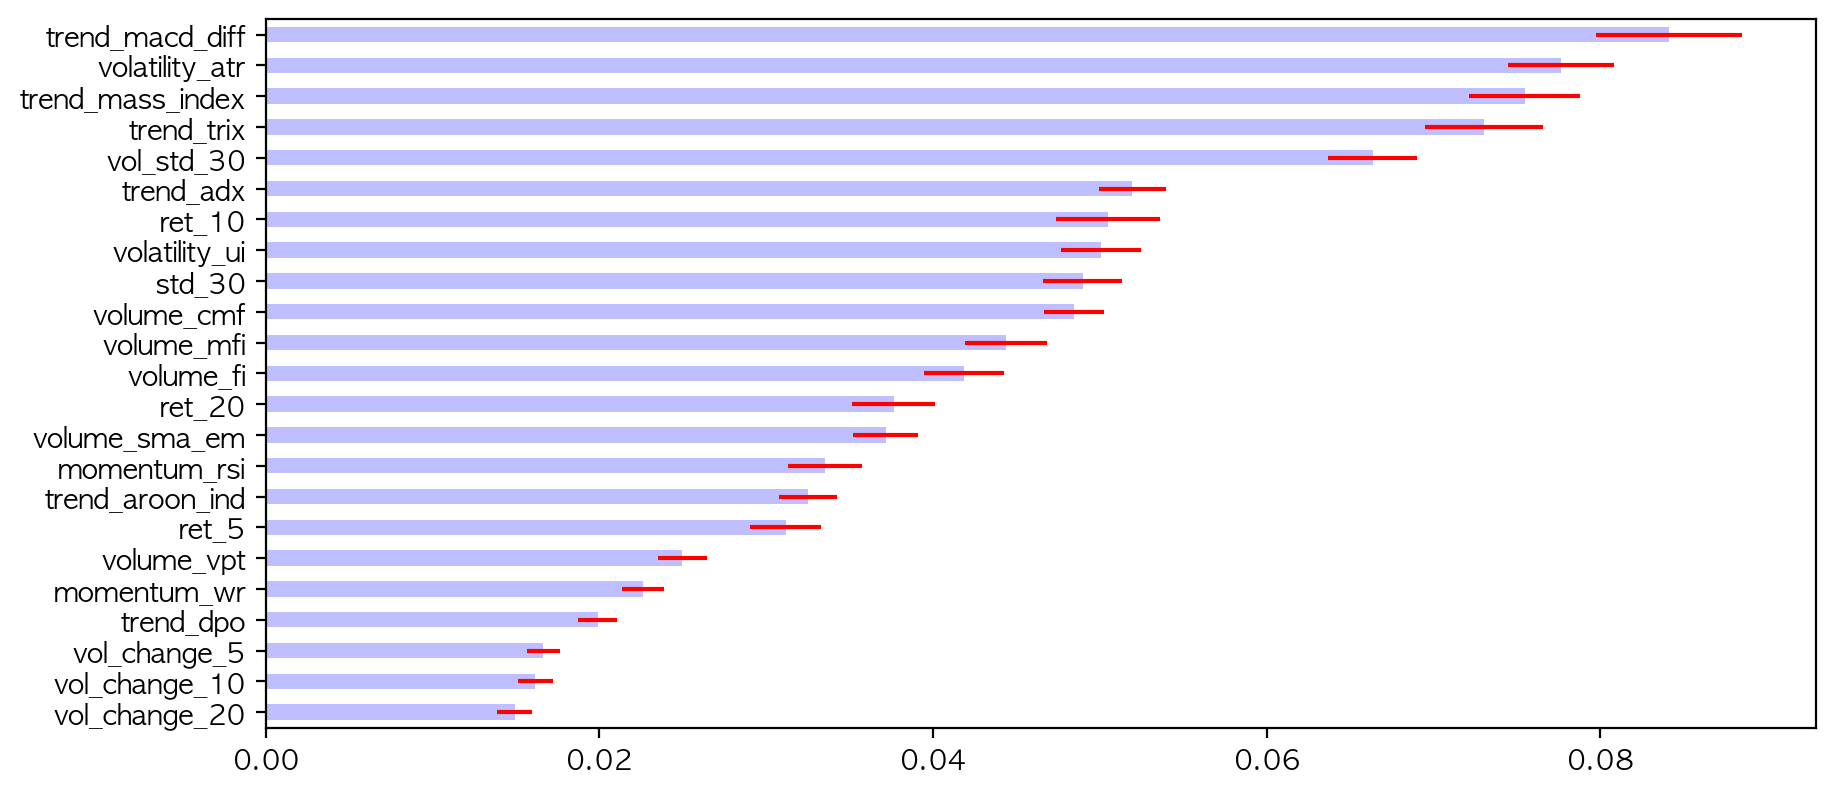

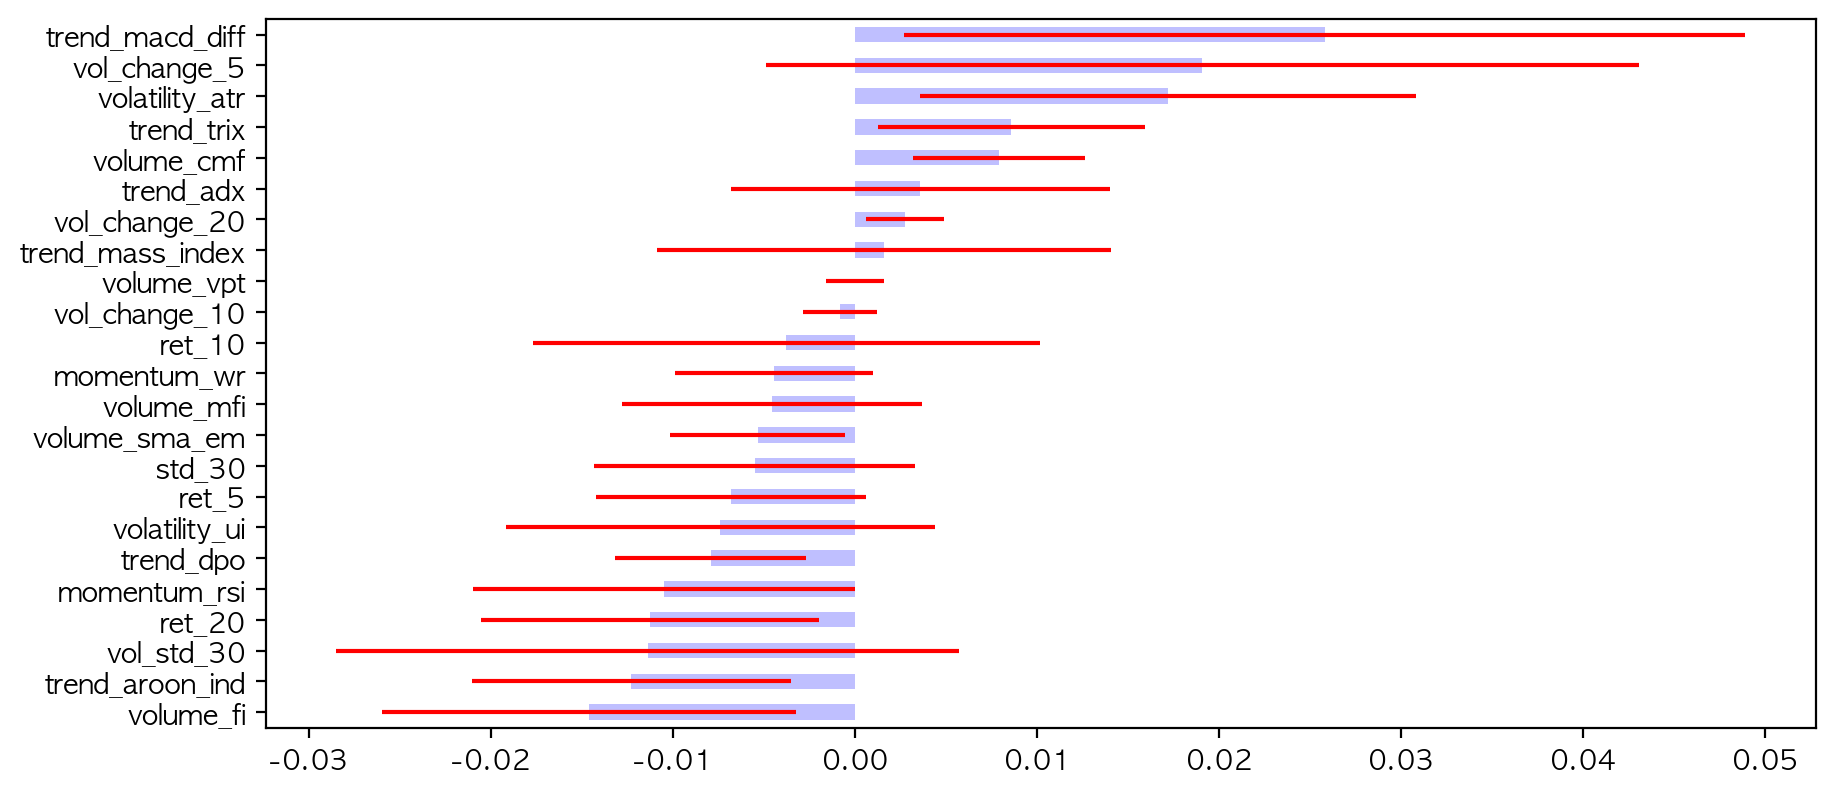

In [42]:
# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

### RFE CV, Recursive Feature Elimination

In [43]:
# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

### SFS, Sequential Feature Selection

In [44]:
# SFS, Sequential Feature Selection
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=2, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

### SHAP, Shapley Additive explanations

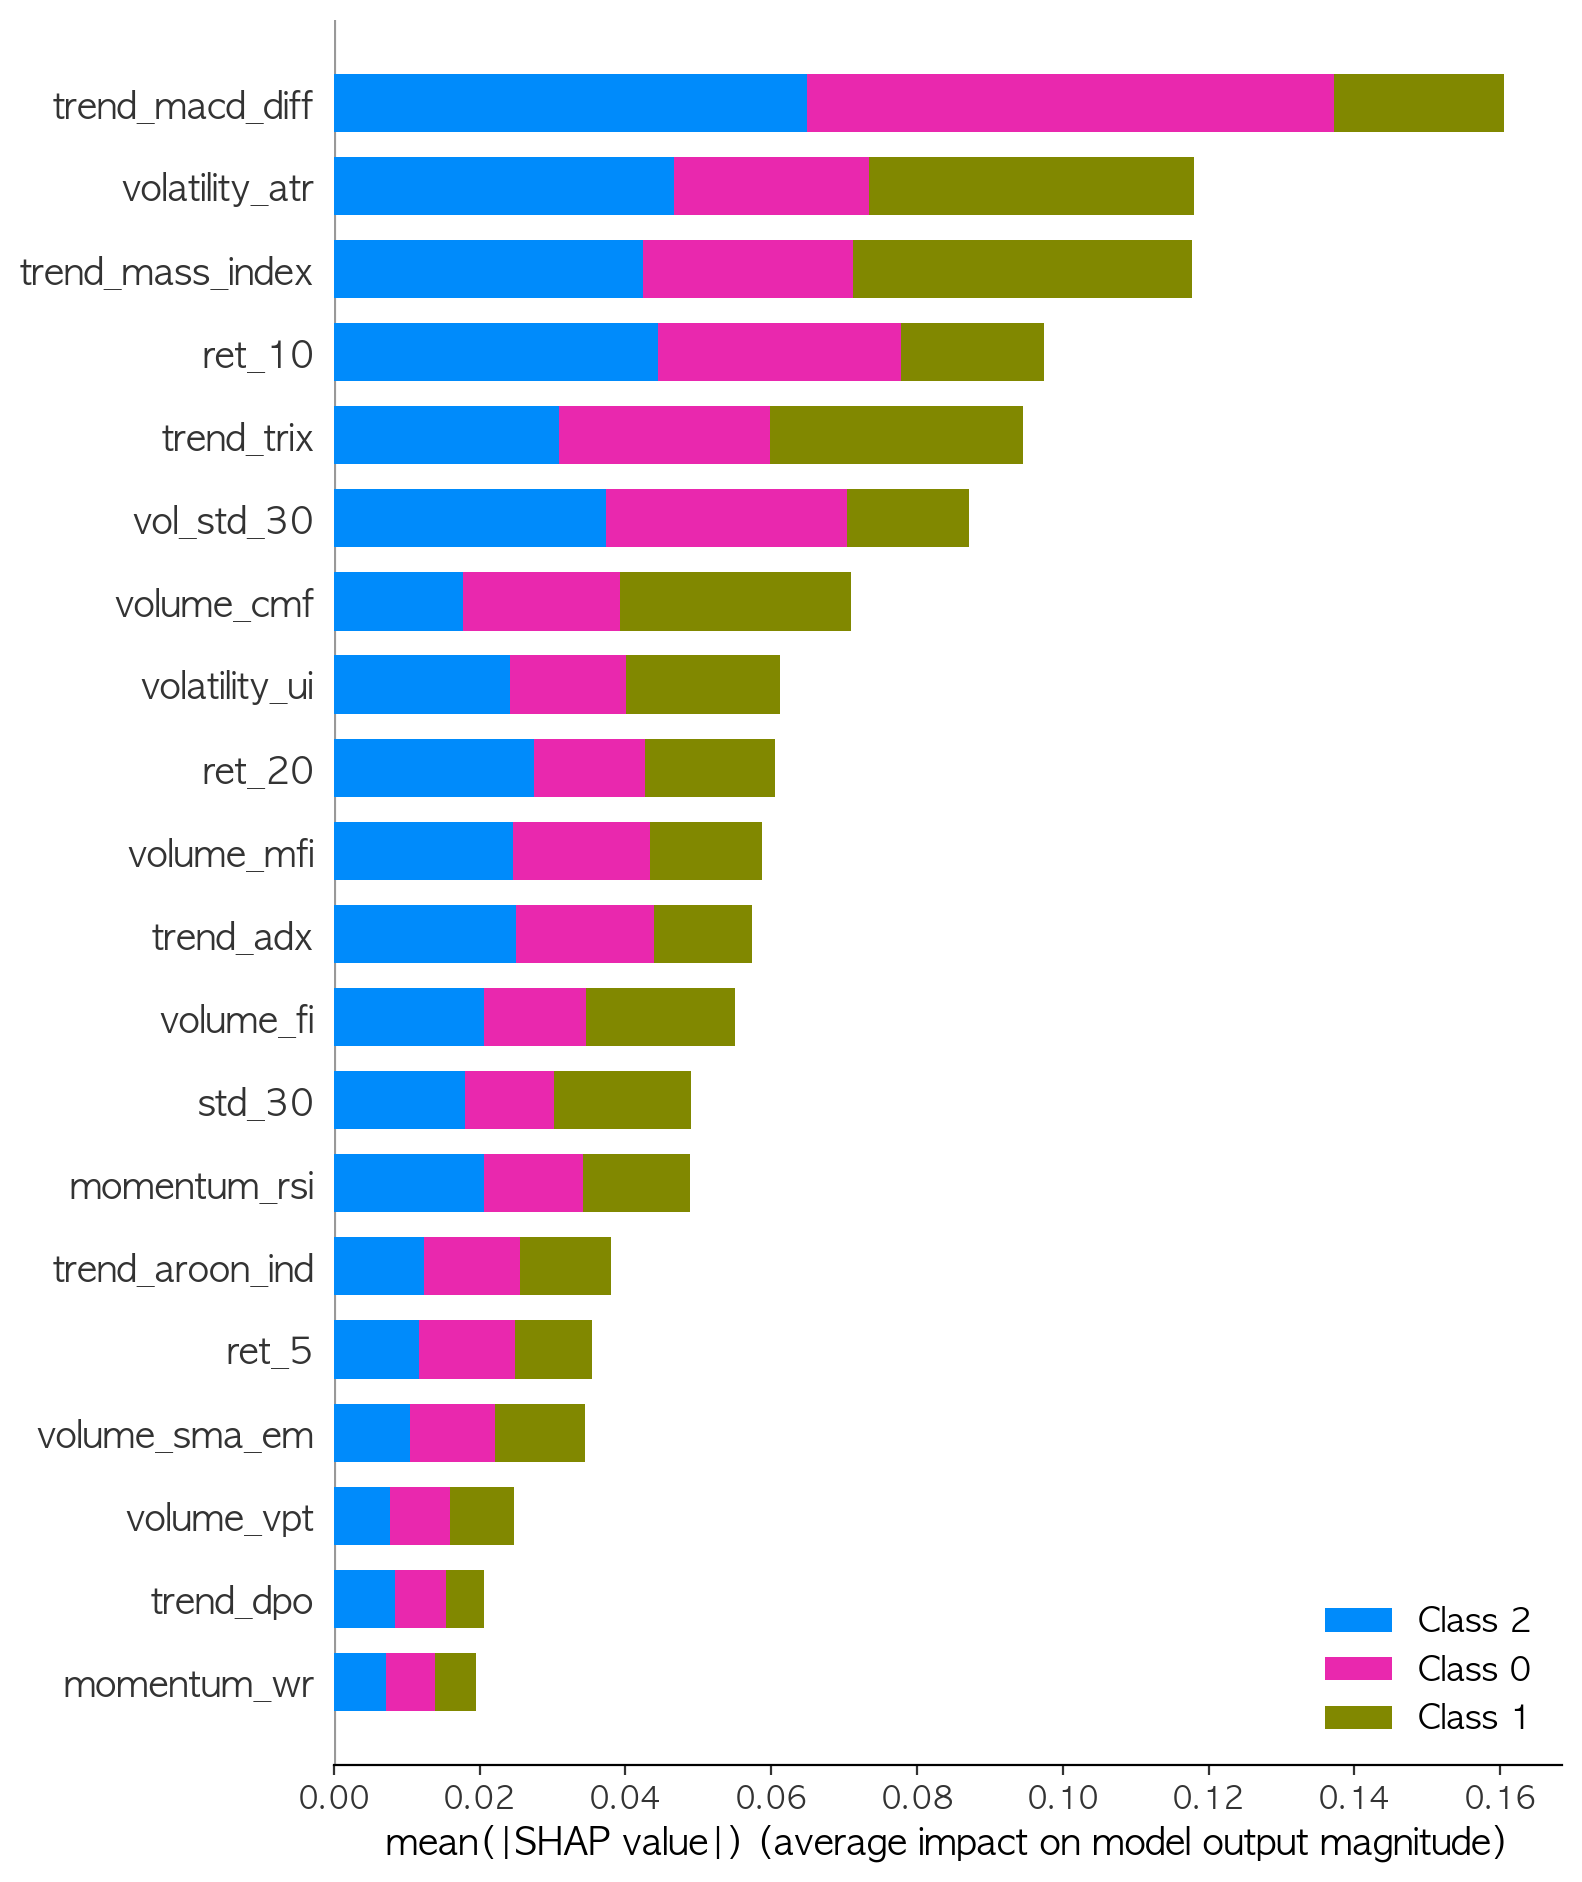

In [45]:
# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value, X_sc)

# 3- 프로젝트 : Model Traning

① 환경구성 및 데이터 불러오기

In [123]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

# sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [74]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/Users/kenny_jung/aiffel/workplace/quest_0304/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

In [75]:
df_data['t_value'].value_counts()

t_value
0.0    609576
1.0    299269
Name: count, dtype: int64

In [76]:
y.value_counts()

t_value
0.0    609576
1.0    299269
Name: count, dtype: int64

In [77]:
train_y.value_counts()

t_value
0.0    519
1.0    481
Name: count, dtype: int64

In [78]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1000, 23), (1000,), (181769, 23), (181769,))

## ② Purged K-fold for Cross-Validation적용하기

In [103]:
n_cv = 3 
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold 
cv = PKFold(n_cv, t1, 0)

In [104]:
t1.shape, cv

((1000,),
 PKFold(n_splits=3, pct_embargo=0,
     samples_info_sets=time
 2018-01-01 00:43:00   2018-01-01 00:43:00
 2018-01-01 00:44:00   2018-01-01 00:44:00
 2018-01-01 00:45:00   2018-01-01 00:45:00
 2018-01-01 00:46:00   2018-01-01 00:46:00
 2018-01-01 00:47:00   2018-01-01 00:47:00
                               ...
 2018-01-01 17:18:00   201...   2018-01-01 17:21:00
 2018-01-01 17:22:00   2018-01-01 17:22:00
 Length: 1000, dtype: datetime64[ns]))

## ③ Model 적용하기

In [117]:
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.3, 0.5, 0.7],
             'base_estimator__max_depth': [2, 3, 5, 10],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [1, 2, 3, 5],
             'bootstrap_features': [False, True]
            }

# Best parameters:  {'base_estimator__max_depth': 3, 
#                    'base_estimator__max_features': None, 
#                    'base_estimator__min_samples_leaf': 2, 
#                    'bootstrap_features': True, 
#                    'max_features': 0.5, 
#                    n_estimators': 5}

In [118]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [119]:
# Bagging 적용
bag_rfc = BaggingClassifier(rfc)

In [120]:
# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

In [121]:
train_x.head()

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.205697,-0.002785,0.372675,-0.004998,0.010214,1.594513,0.124693,0.102045,0.436886,0.089196,...,0.062593,0.277795,-0.002679,0.000674,-0.001241,0.001057,-0.00121,0.657870,0.389191,-0.355026
2018-01-01 00:44:00,1.220216,0.048822,0.313851,0.006665,0.034188,1.596590,0.097394,0.654980,0.316213,0.112187,...,0.524856,1.248577,-0.002679,2.097148,-0.001241,0.100937,-0.00121,0.948546,0.429687,-0.353016
2018-01-01 00:45:00,1.211574,0.024138,0.370960,0.013252,0.014705,1.508725,0.069233,0.731476,0.184842,0.142536,...,0.260815,0.718242,-0.002679,0.557674,-0.001241,0.201021,-0.00121,0.949877,0.443664,-0.351891
2018-01-01 00:46:00,1.190577,0.173317,0.105866,0.009813,0.065506,1.668937,0.069233,1.474435,0.075168,0.217261,...,0.941719,1.572171,-0.002678,2.370971,-0.001241,0.799692,-0.00121,1.605597,0.562691,-0.356863
2018-01-01 00:47:00,1.094608,0.108411,-0.109812,-0.016541,0.053176,1.813129,0.150275,0.945003,-0.027195,0.268868,...,0.015061,-0.031730,-0.002679,0.418495,-0.001241,0.101141,-0.00121,0.511349,0.565264,-0.350154


In [122]:
train_y.value_counts()

t_value
0.0    519
1.0    481
Name: count, dtype: int64

In [124]:
# fit
gs_rfc.fit(train_x, train_y)

# best estimator 
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

# print best parameters
print("Best parameters: ", gs_rfc.best_params_)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/kenny_jun

Best parameters:  {'base_estimator__max_depth': 5, 'base_estimator__max_features': None, 'base_estimator__min_samples_leaf': 5, 'bootstrap_features': True, 'max_features': 0.3, 'n_estimators': 5}


In [125]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [126]:
# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[112110   9202]
 [ 50226  10231]]
정확도:0.6730575620705401, 정밀도:0.5264755827715741, 재현율:0.16922771556643565


auc:0.5466868596296963


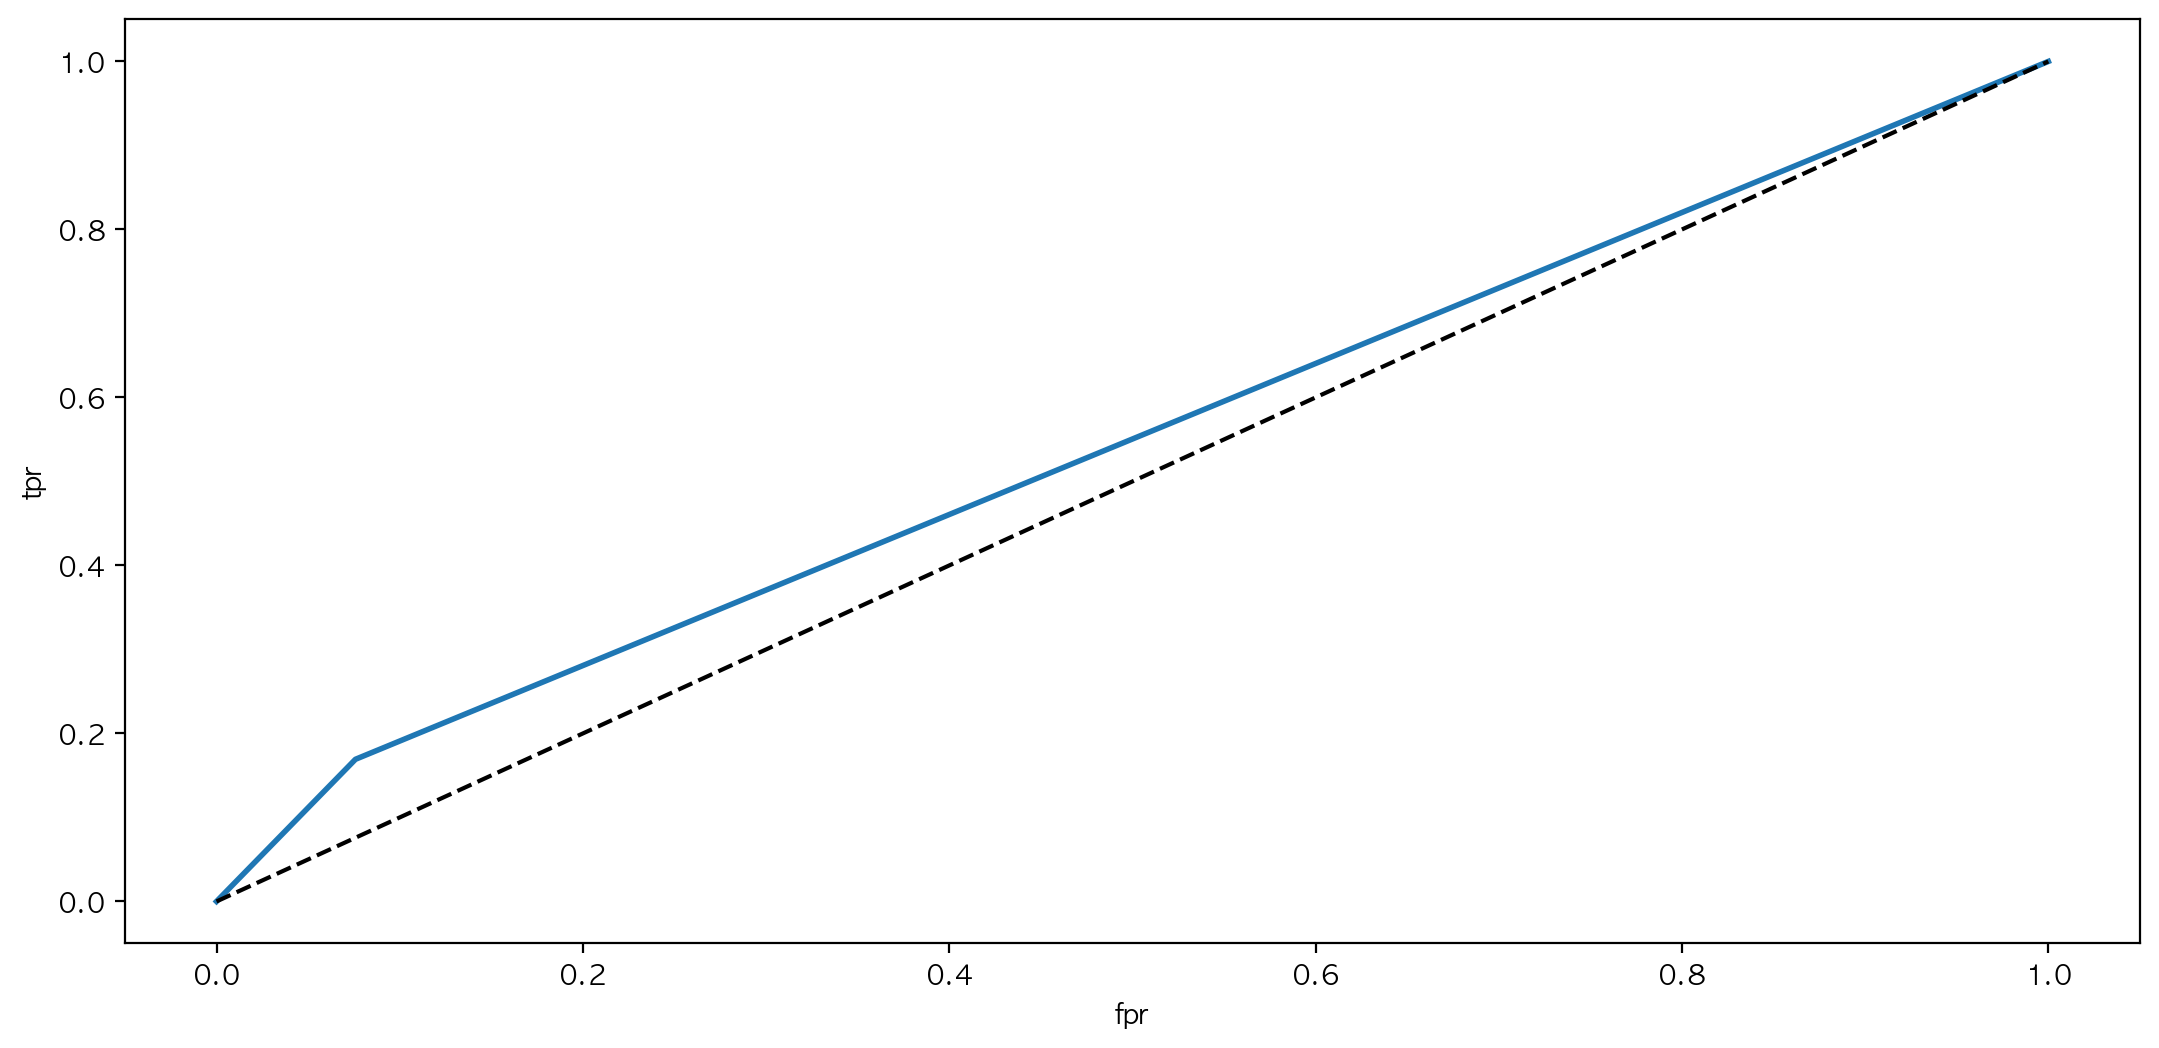

In [127]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')